# CAP-4770: Final Project

## Overview

This project aims to enhance a Random Forest Classifier by employing stacking. The intended stacked features are: cluster purity and ID, Naive Bayes Classifier results, and a simple word count.

While we aim to improve a classifier, the learning goals of this project seek to explore an application of the following subjects discussed this semester in class: Principal Component Analysis, Count vectorization, TF-IDF vectorization, K-Means clustering, Naive Bayes classification, and Random Forest Classifier. To that end, the data analysis will be limited to these subjects.

## 1. Import

First, we will import all needed libraries/classes and define any helper functions.

In [1]:
# Imports

# Standard library
import random
import sqlite3

# Numerical & Data Handling
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.stats import chi2_contingency, entropy, norm

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from statsmodels.stats.proportion import proportions_ztest

# scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, silhouette_score, normalized_mutual_info_score, 
                             adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score)

In [2]:
# Helper Functions

def vectorize_and_reduce(x_titles, vectorizer, n_components=2):
    """
    Vectorize text and apply PCA reduction.

    Parameters:
    - x_titles: list of text strings
    - vectorizer: sklearn vectorizer (e.g., CountVectorizer or TfidfVectorizer)
    - n_components: number of PCA components to keep

    Returns:
    - pca: fitted PCA instance
    - x_pca: PCA-transformed array
    """
    x_vec = vectorizer.fit_transform(x_titles).toarray()
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x_vec)
    return pca, x_pca


def plot_pca_projection(x_pca, y_labels, vec_name="Vectorizer"):
    """
    Plot 2D PCA projection of text data, color-coded by label.

    Parameters:
    - x_pca: 2D PCA-reduced feature matrix
    - y_labels: list of labels ('0' or '1')
    - vec_name: string label for plot title
    """
    colors = ["blue" if label == "0" else "red" for label in y_labels]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_pca[:, 0], x_pca[:, 1], c=colors, alpha=0.6)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Real News',
               markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Fake News',
               markerfacecolor='red', markersize=10)
    ]

    plt.legend(handles=legend_elements, title="Legend")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(f"2D PCA Projection ({vec_name})")
    plt.grid(True)
    plt.show()


def display_pca_words(components, features, n=20):
    """
    Show top positive and negative contributing words for PC1 and PC2.

    Parameters:
    - components: PCA components matrix
    - features: list or array of feature names
    - n: number of top/bottom features to display
    """
    assert components.shape[0] >= 2, "Need at least 2 PCA components."

    def top_words(pc):
        return features[pc.argsort()[:n]], features[pc.argsort()[::-1][:n]]

    pc1_neg, pc1_pos = top_words(components[0])
    pc2_neg, pc2_pos = top_words(components[1])

    df = pd.DataFrame({
        "PC1 Negative": pc1_neg,
        "PC1 Positive": pc1_pos,
        "PC2 Negative": pc2_neg,
        "PC2 Positive": pc2_pos
    })

    display(df)

    '''
    # Words Driving PC1 and PC2
    components = pca.components_
    features = tfidf_vectorizer.get_feature_names_out()
    
    display_pca_words(components, features, 10)
    '''


def evaluate_clustering_model(pca_data, true_labels, k_range=range(2, 31)):
    """
    Evaluate KMeans clustering over a range of k using clustering quality metrics.

    Parameters:
    - pca_data: 2D PCA-transformed data
    - true_labels: list of ground-truth labels
    - k_range: iterable of k values
    """
    results = []

    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(pca_data)

        sil = silhouette_score(pca_data, labels)
        ari = adjusted_rand_score(true_labels, labels)
        nmi = normalized_mutual_info_score(true_labels, labels)

        results.append({
            "K": k,
            "Silhouette": sil,
            "Inertia": model.inertia_,
            "ARI": ari,
            "NMI": nmi
        })

    df = pd.DataFrame(results)
    display(df)


def analyze_cluster_purity(pca, cluster_labels, sample_labels):
    """
    Visualize cluster structure and purity.

    Parameters:
    - pca: 2D PCA-reduced data
    - cluster_labels: predicted cluster assignments
    - sample_labels: true labels ('0' or '1')
    """
    cluster_labels = np.array(cluster_labels)
    sample_labels = np.array(sample_labels)
    num_clusters = len(np.unique(cluster_labels))
    cmap = plt.get_cmap("tab10", num_clusters)

    def get_fake_pct_per_cluster():
        return [
            np.mean(sample_labels[cluster_labels == i] == '1')
            for i in range(num_clusters)
        ]

    fake_pcts = get_fake_pct_per_cluster()
    overall_fake_pct = np.mean(sample_labels == '1')

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # PCA Scatter
    ax = axes[0]
    for i in range(num_clusters):
        mask = cluster_labels == i
        ax.scatter(pca[mask, 0], pca[mask, 1], color=cmap(i), label=f"Cluster {i}", alpha=0.6)
    ax.set_title("KMeans Clustering (PCA)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()

    # Bar Chart
    ax = axes[1]
    bars = ax.bar(range(num_clusters), fake_pcts, color=[cmap(i) for i in range(num_clusters)])
    ax.axhline(overall_fake_pct, color='red', linestyle='--', linewidth=2, label="Overall Fake %")
    ax.set_title("Cluster Purity (Fake News %)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Fake News Percentage")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(num_clusters))
    ax.set_xticklabels([f"C{i}" for i in range(num_clusters)])
    ax.legend()

    plt.tight_layout()
    plt.show()


def evaluate_cluster_predictivity(pca, cluster_labels, true_labels):
    """
    Assess cluster utility for classification and structure.

    Metrics:
    - Logistic regression accuracy
    - Adjusted Rand Index (ARI)
    - Normalized Mutual Information (NMI)
    - Silhouette Score

    Parameters:
    - pca: PCA-reduced data
    - cluster_labels: predicted cluster assignments
    - true_labels: true class labels ('0' or '1')
    """
    cluster_onehot = pd.get_dummies(cluster_labels, prefix="Cluster")

    clf = LogisticRegression(max_iter=1000)
    acc = cross_val_score(clf, cluster_onehot, true_labels, scoring='accuracy', cv=5).mean()
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    sil = silhouette_score(pca, cluster_labels)

    print("Cluster Predictiveness Evaluation:")
    print(f"  Accuracy (LogReg): {acc:.3f}")
    print(f"  ARI: {ari:.3f}")
    print(f"  NMI: {nmi:.3f}")
    print(f"  Silhouette Score: {sil:.3f}")

## 2. Pre-Processing

Second, we will generate the data frame (df) from the project's database, ensuring that all NULL entries are excluded, and verify that the df is constructed as expected.

In [3]:
# Build DF from DB, Remove NULL entries

conn = sqlite3.connect("../WELFake_Dataset.db")
df = pd.read_sql(
    "SELECT id, title, label FROM WELFake_Dataset WHERE title IS NOT NULL", 
    conn,  
    index_col="id"
)

In [4]:
# Check DF
df.info(verbose=True)
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 71576 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   label   71576 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


,title,label
id,,
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1


## 3. Exploratory Data Analysis

To reduce computational loads, the data analysis will be conducted using a random sample drawn from the dataset. This will enable us to complete computationally intensive tasks, such as Principal Component Analysis, within the limitations of a personal computer.

The dataset contains approximately 70,000 tuples. Through trial and error, it was determined that 10,000 was the upper end of my personal machine's capability.

In [5]:
# Get Sample
sample = df.sample(n=10000, random_state=42)
titles_sample = sample['title'].tolist()
labels_sample = sample['label'].tolist()

Now that the sample is collected, we will use it to help determine what vectorization method should be used. 

**Note:** We will remain in a two-dimensional space; the reason for this is twofold: it benefits visualization and, through testing, yields similar predictive results as four- and eight-dimensional spaces.

### Visualize Data with Count Vectorizing, PCA, and K-Means

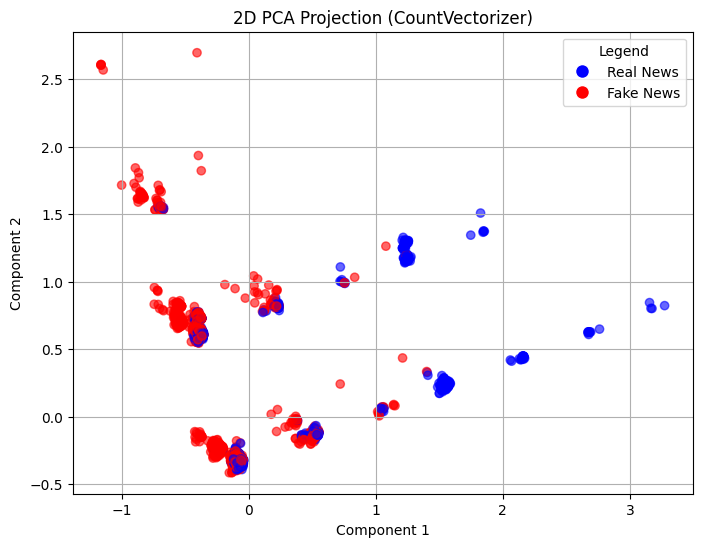

In [6]:
# Visualize Data (Count Vectorizer) and Plot with 2D PCA
vectorizer = CountVectorizer(stop_words='english', min_df=2)

pca, x_pca = vectorize_and_reduce(titles_sample, vectorizer, 2)
plot_pca_projection(x_pca, labels_sample, vec_name="CountVectorizer")

In [7]:
# Find Optimal Number of Clusters
evaluate_clustering_model(x_pca, labels_sample, range(12, 16))

,K,Silhouette,Inertia,ARI,NMI
0,12,0.832709,26.443197,0.024783,0.121896
1,13,0.832919,23.245365,0.024818,0.122474
2,14,0.833650,17.147791,0.024803,0.122409
3,15,0.834518,14.995734,0.024769,0.122272


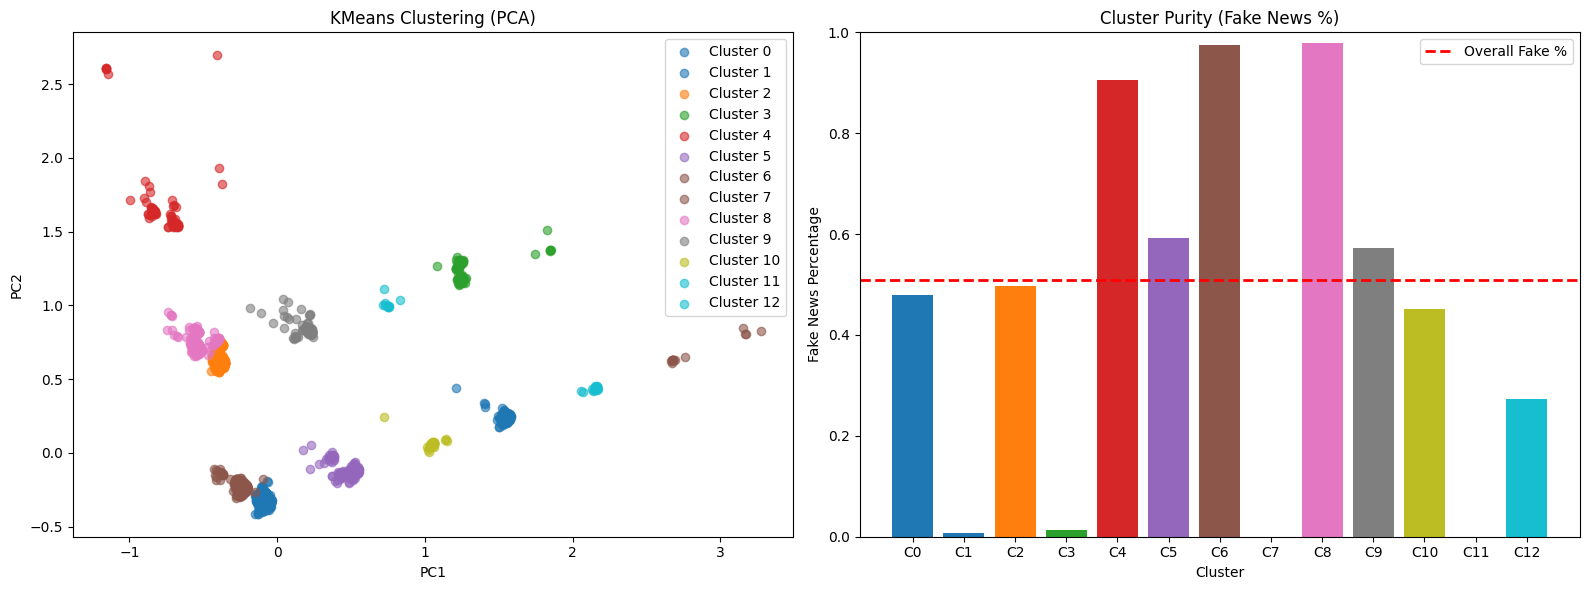

In [8]:
# Perform Cluster Analysis
kmeans = KMeans(n_clusters=13, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(x_pca)
analyze_cluster_purity(x_pca, cluster_labels_kmeans, labels_sample)

In [9]:
# Determine Cluster Predictivity
evaluate_cluster_predictivity(x_pca, cluster_labels_kmeans, labels_sample)

Cluster Predictiveness Evaluation:
  Accuracy (LogReg): 0.615
  ARI: 0.025
  NMI: 0.122
  Silhouette Score: 0.833


### Visualize Data with TF-IDF Vectorizing, PCA, and K-Means

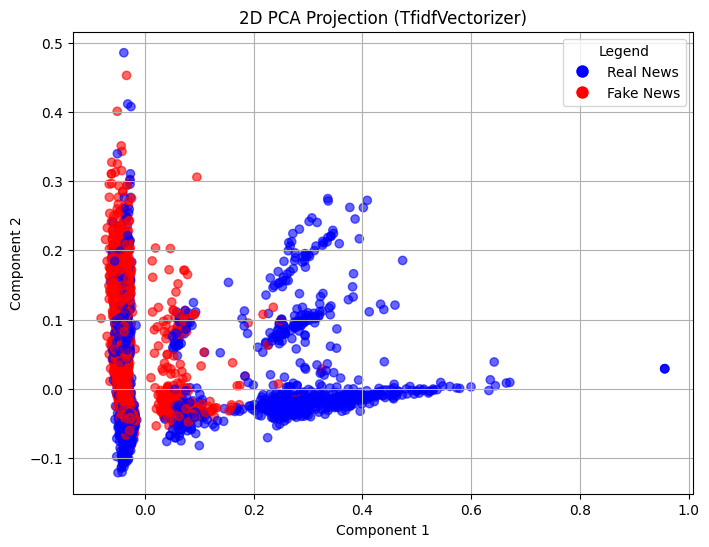

In [10]:
# Visualize Data (TF-IDF Vectorizer) and Plot with 2D PCA
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)

pca, x_pca = vectorize_and_reduce(titles_sample, tfidf_vectorizer, 2)
plot_pca_projection(x_pca, labels_sample, vec_name="TfidfVectorizer")

In [11]:
# Find Optimal Number of Clusters
evaluate_clustering_model(x_pca, labels_sample, range(12, 17))

,K,Silhouette,Inertia,ARI,NMI
0,12,0.493896,5.141166,0.039512,0.098371
1,13,0.485429,4.807356,0.038400,0.096352
2,14,0.496366,4.123090,0.038380,0.096147
3,15,0.491221,3.636286,0.038171,0.093840
4,16,0.489292,3.495235,0.038193,0.094651


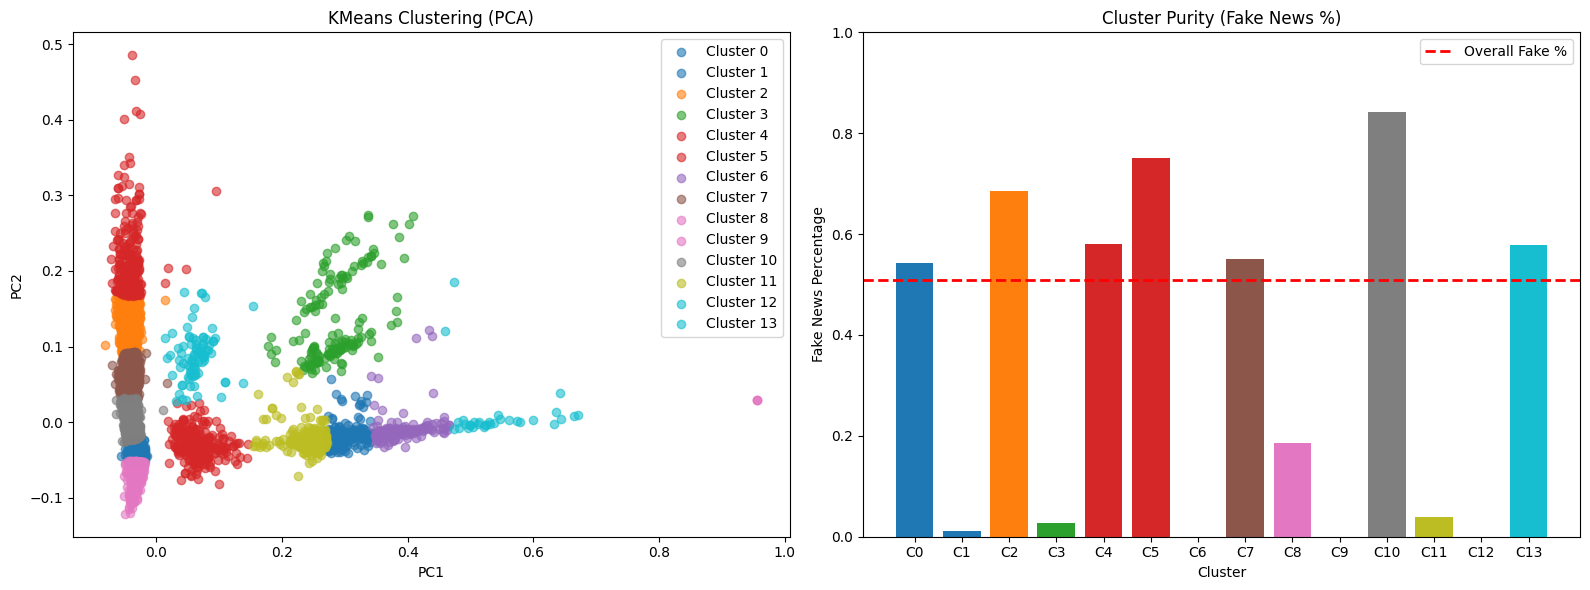

In [12]:
# Perform Cluster Analysis
kmeans = KMeans(n_clusters=14, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(x_pca)
analyze_cluster_purity(x_pca, cluster_labels_kmeans, labels_sample)

In [13]:
# Determine Cluster Predictivity
evaluate_cluster_predictivity(x_pca, cluster_labels_kmeans, labels_sample)

Cluster Predictiveness Evaluation:
  Accuracy (LogReg): 0.676
  ARI: 0.038
  NMI: 0.096
  Silhouette Score: 0.496


### Determine Best Params for Random Forest Classifier

In [14]:
# Determine RF Best Params

# Classifier Param Testing
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 50],
    'max_features': ['sqrt', 0.2, 0.5],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=0,
    random_state=42
)

# Vectorize titles
vec = tfidf_vectorizer.fit_transform(titles_sample)

# Convert labels to int
labels_int = np.array(labels_sample).astype(int)

# Run random search
random_search.fit(vec, labels_int)

# Show Best Parameters
print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
0.8525912739116573


## 4. Modeling

### Data Prep

In [15]:
# Split DF
titles = df['title']
labels = df['label']
titles_train, titles_test, labels_train, labels_test = train_test_split(
    titles,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
pca, x_pca = vectorize_and_reduce(titles_sample, tfidf_vectorizer, 2)

In [17]:
# Vectorize
x_train = tfidf_vectorizer.transform(titles_train)
x_test = tfidf_vectorizer.transform(titles_test)

In [18]:
# Reduce (test 8 and 16)
x_train_reduced = pca.transform(x_train)
x_test_reduced = pca.transform(x_test)

In [19]:
# Cluster
kmeans = KMeans(n_clusters=14, random_state=42)
kmeans.fit_predict(x_pca)
cluster_labels_train = kmeans.predict(x_train_reduced)
cluster_labels_test = kmeans.predict(x_test_reduced)

### Random Forest

In [20]:
# Fit RF Classifier (built with best params)
best_rf_params = {
    'n_estimators': 100,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': None,
    'class_weight': 'balanced',
}

clf_RF = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
clf_RF.fit(x_train, labels_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
# Check RF Classifier Accuracy
y_pred = clf_RF.predict(x_test)
print("Accuracy: ", accuracy_score(labels_test, y_pred))
print(classification_report(labels_test, y_pred))

Accuracy:  0.8857635169748056
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     10508
           1       0.89      0.89      0.89     10965

    accuracy                           0.89     21473
   macro avg       0.89      0.89      0.89     21473
weighted avg       0.89      0.89      0.89     21473



### Naive Bayes

In [22]:
# Fit NB
clf_NB = MultinomialNB()
clf_NB.fit(x_train, labels_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [23]:
# Predict
y_pred = clf_NB.predict(x_test)
print("Accuracy: ", accuracy_score(labels_test, y_pred))
print(classification_report(labels_test, y_pred))

Accuracy:  0.8713733525823126
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     10508
           1       0.87      0.88      0.87     10965

    accuracy                           0.87     21473
   macro avg       0.87      0.87      0.87     21473
weighted avg       0.87      0.87      0.87     21473



## Build Composit Classifier

In [24]:
# Find Word Count (title_word_count)
titles_training_wc = np.array([len(title.split()) for title in titles_train]).reshape(-1, 1)
titles_training_wc = sparse.csr_matrix(titles_training_wc)

titles_test_wc = np.array([len(title.split()) for title in titles_test]).reshape(-1, 1)
titles_test_wc = sparse.csr_matrix(titles_test_wc)

In [25]:
# Find % Fake News per Cluster
labels_train_arr = np.array(labels_train)
labels_train_int = (labels_train_arr == '1').astype(int)

cluster_fake_pct_dict = {}
for cluster_id in np.unique(cluster_labels_train):
    mask = cluster_labels_train == cluster_id
    labels_in_cluster = labels_train_int[mask]
    fake_pct = np.sum(labels_in_cluster) / len(labels_in_cluster)
    cluster_fake_pct_dict[cluster_id] = fake_pct

In [26]:
# Create Cluster Features (cluster_id_feature_train, cluster_fake_pct_feature_train)

# Training Set
cluster_id_feature_train = cluster_labels_train.reshape(-1, 1)

cluster_fake_pct_feature_train = np.array([
    cluster_fake_pct_dict[cid] for cid in cluster_labels_train
]).reshape(-1, 1)

# Test Set
cluster_id_feature_test = cluster_labels_test.reshape(-1, 1)

cluster_fake_pct_feature_test = np.array([
    cluster_fake_pct_dict.get(cid, 0.5) for cid in cluster_labels_test
]).reshape(-1, 1)

In [27]:
# Create NB Feature (nb_probs_train)

# Training Set
nb_probs_train = clf_NB.predict_proba(x_train)[:, 1].reshape(-1, 1)

# Test Set
nb_probs_test = clf_NB.predict_proba(x_test)[:, 1].reshape(-1, 1)

In [28]:
# Combine

# Train
x_train_combined = sparse.hstack([
    x_train,
    cluster_id_feature_train,
    cluster_fake_pct_feature_train,
    nb_probs_train,
    titles_training_wc
])

# Test
x_test_combined = sparse.hstack([
    x_test,
    cluster_id_feature_test,
    cluster_fake_pct_feature_test,
    nb_probs_test,
    titles_test_wc
])

In [29]:
# Fit and Check RF Composit Classifier
clf_RF.fit(x_train_combined, labels_train)

# Predict on test set
y_pred = clf_RF.predict(x_test_combined)

# Evaluate
print(classification_report(labels_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.913     0.899     0.906     10508
           1      0.905     0.918     0.911     10965

    accuracy                          0.909     21473
   macro avg      0.909     0.908     0.909     21473
weighted avg      0.909     0.909     0.909     21473



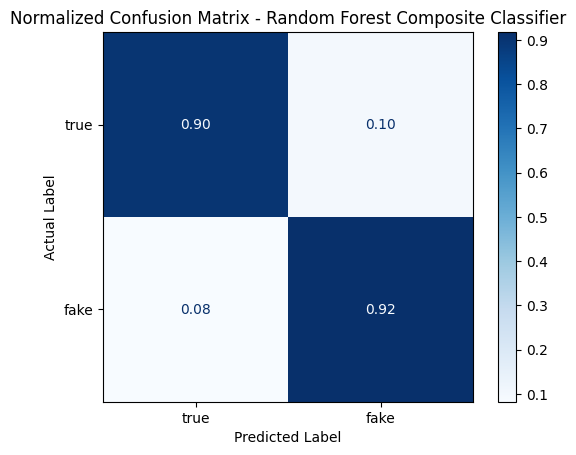

In [30]:
# Check Normalized Confusion Matrix

# Define labels
label_mapping = {
    "0": "true",
    "1": "fake"
}

custom_labels = ["true", "fake"]

# Normalized confusion matrix
cm_normalized = confusion_matrix(
    labels_test,
    y_pred,
    labels=["0", "1"],
    normalize='true'
)

disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                         display_labels=custom_labels)

disp_normalized.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix - Random Forest Composite Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

## 5. Conclusions

In [32]:
# Classify Titles
new_titles = [
    # Real news examples
    "Scientists discover new planet",
    "Local elections see record turnout",
    "New study shows benefits of exercise",
    "Government releases economic forecast",
    "NASA announces new Mars mission",
    "Researchers develop promising cancer treatment",
    "Weather service warns of approaching storm",
    "UN holds emergency meeting on global conflict",
    "Tech company reports surge in quarterly profits",
    "Historic peace deal signed between nations",

    # Fake news examples
    "Politician caught in alien conspiracy",
    "Doctors hide cure for cancer to protect profits",
    "New world order plans revealed by secret documents",
    "Scientists admit Earth is flat in shocking report",
    "Celebrity reveals time travel secrets on live TV",
    "Government replaces citizens with clones",
    "Bill Gates microchips confirmed in vaccines",
    "Alien bases discovered under the White House",
    "Vampires spotted in national park",
    "FBI confirms psychic powers exist"
]

# Vector Feature
vectors = tfidf_vectorizer.transform(new_titles)

# Find Word Count (title_word_count)
titles_wc = np.array([len(title.split()) for title in new_titles]).reshape(-1, 1)
titles_wc = sparse.csr_matrix(titles_wc)

# NB Feature
nb_probs = clf_NB.predict_proba(vectors)[:, 1].reshape(-1, 1)

# Reduce
reduced = pca.transform(vectors)

# Cluster
clusters = kmeans.predict(reduced)

# Cluster ID Feature
cluster_ids = clusters.reshape(-1, 1)

# Cluster Fake Pct Feature
cluster_fake_pct_dict = {cid: 0.5 for cid in np.unique(clusters)}

cluster_fake_pct = np.array([
    cluster_fake_pct_dict[cid] for cid in clusters
]).reshape(-1, 1)

# Combine Features
combined = sparse.hstack([
    vectors,
    cluster_ids,
    cluster_fake_pct,
    nb_probs,
    titles_wc
])

predictions = clf_RF.predict(combined)
probs = clf_RF.predict_proba(combined)[:, 1] 

# Print results
print("-" * 50)
for title, label, prob in zip(new_titles, predictions, probs):
    label_str = "True" if label == 0 else "Fake"
    print(f"Title: {title}")
    print(f"Predicted label: {label_str}")
    print(f"Probability Fake: {prob*100:.1f}%")
    print("-" * 50)

--------------------------------------------------
Title: Scientists discover new planet
Predicted label: Fake
Probability Fake: 76.9%
--------------------------------------------------
Title: Local elections see record turnout
Predicted label: Fake
Probability Fake: 79.7%
--------------------------------------------------
Title: New study shows benefits of exercise
Predicted label: Fake
Probability Fake: 46.8%
--------------------------------------------------
Title: Government releases economic forecast
Predicted label: Fake
Probability Fake: 49.3%
--------------------------------------------------
Title: NASA announces new Mars mission
Predicted label: Fake
Probability Fake: 44.7%
--------------------------------------------------
Title: Researchers develop promising cancer treatment
Predicted label: Fake
Probability Fake: 83.9%
--------------------------------------------------
Title: Weather service warns of approaching storm
Predicted label: Fake
Probability Fake: 71.4%
---------